In [2]:
# Cell 1: Imports and Data Load

import pandas as pd

# Load the first 25 000 rows
df = pd.read_csv('../files/first_25000_rows.csv')
df.head()


,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2024-10-21T11:54:29.221230963Z,2024-10-21T11:54:29.221064336Z,10,2,38,C,B,1,233.62,2,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
1,2024-10-21T11:54:29.223936626Z,2024-10-21T11:54:29.223769812Z,10,2,38,A,B,0,233.67,2,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
2,2024-10-21T11:54:29.225196809Z,2024-10-21T11:54:29.225030400Z,10,2,38,A,B,0,233.67,3,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
3,2024-10-21T11:54:29.712600612Z,2024-10-21T11:54:29.712434212Z,10,2,38,A,B,2,233.52,200,...,155,1,7,233.25,234.13,55,400,2,1,AAPL
4,2024-10-21T11:54:29.764839221Z,2024-10-21T11:54:29.764673165Z,10,2,38,C,B,2,233.52,200,...,155,1,7,233.25,234.13,55,400,2,1,AAPL


In [3]:
# Cell 2: Parse and sort by event timestamp

# Convert event timestamp to pandas datetime
df['ts_event'] = pd.to_datetime(df['ts_event'])

# Sort in chronological order
df = df.sort_values('ts_event').reset_index(drop=True)
df[['ts_event']].head()


,ts_event
0,2024-10-21 11:54:29.221064336+00:00
1,2024-10-21 11:54:29.223769812+00:00
2,2024-10-21 11:54:29.225030400+00:00
3,2024-10-21 11:54:29.712434212+00:00
4,2024-10-21 11:54:29.764673165+00:00


In [4]:
# Cell 3: Prepare “previous” quotes for each depth level

# Define the depth levels you want (here 0 through 9)
levels = list(range(10))

for lvl in levels:
    px_col = f'bid_px_{lvl:02d}'
    sz_col = f'bid_sz_{lvl:02d}'
    df[f'prev_{px_col}'] = df[px_col].shift(1)
    df[f'prev_{sz_col}'] = df[sz_col].shift(1)
    
    px_col_a = f'ask_px_{lvl:02d}'
    sz_col_a = f'ask_sz_{lvl:02d}'
    df[f'prev_{px_col_a}'] = df[px_col_a].shift(1)
    df[f'prev_{sz_col_a}'] = df[sz_col_a].shift(1)

# Inspect for level 0 and level 1
df[[ 'bid_px_00','prev_bid_px_00','bid_sz_00','prev_bid_sz_00',
     'ask_px_00','prev_ask_px_00','ask_sz_00','prev_ask_sz_00',
     'bid_px_01','prev_bid_px_01','bid_sz_01','prev_bid_sz_01'
    ]].head()


,bid_px_00,prev_bid_px_00,bid_sz_00,prev_bid_sz_00,ask_px_00,prev_ask_px_00,ask_sz_00,prev_ask_sz_00,bid_px_01,prev_bid_px_01,bid_sz_01,prev_bid_sz_01
0,233.67,NaN,139,NaN,233.74,NaN,200,NaN,233.53,NaN,10,NaN
1,233.67,233.67,141,139.0,233.74,233.74,200,200.0,233.53,233.53,10,10.0
2,233.67,233.67,144,141.0,233.74,233.74,200,200.0,233.53,233.53,10,10.0
3,233.67,233.67,144,144.0,233.74,233.74,200,200.0,233.53,233.53,10,10.0
4,233.67,233.67,144,144.0,233.74,233.74,200,200.0,233.53,233.53,10,10.0


In [5]:
# Cell 4: Define the flow‐computation function

def compute_flow(current_price, prev_price, current_size, prev_size):
    """
    If price moves up: count full current_size (+).
    If price moves down: count full current_size (−).
    If unchanged: net change in size.
    """
    if current_price > prev_price:
        return  current_size
    elif current_price < prev_price:
        return -current_size
    else:
        return current_size - prev_size


In [6]:
# Cell 5: Compute bid & ask flows for each level, then per‐event Multi‐Level OFI

# Compute flows level by level
for lvl in levels:
    # best‐level bid flow at this depth
    df[f'bid_flow_{lvl}'] = df.apply(
        lambda r: compute_flow(
            r[f'bid_px_{lvl:02d}'], r[f'prev_bid_px_{lvl:02d}'],
            r[f'bid_sz_{lvl:02d}'], r[f'prev_bid_sz_{lvl:02d}']
        ), axis=1
    )
    # best‐level ask flow at this depth
    df[f'ask_flow_{lvl}'] = df.apply(
        lambda r: compute_flow(
            r[f'prev_ask_px_{lvl:02d}'], r[f'ask_px_{lvl:02d}'],
            r[f'prev_ask_sz_{lvl:02d}'], r[f'ask_sz_{lvl:02d}']
        ), axis=1
    )

# Sum flows across all levels
bid_flow_cols = [f'bid_flow_{lvl}' for lvl in levels]
ask_flow_cols = [f'ask_flow_{lvl}' for lvl in levels]

df['ofi_multilevel_event'] = df[bid_flow_cols].sum(axis=1) - df[ask_flow_cols].sum(axis=1)

df[[*bid_flow_cols[:2], *ask_flow_cols[:2], 'ofi_multilevel_event']].head()


,bid_flow_0,bid_flow_1,ask_flow_0,ask_flow_1,ofi_multilevel_event
0,NaN,NaN,NaN,NaN,0.0
1,2.0,0.0,0.0,0.0,2.0
2,3.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,200.0
4,0.0,0.0,0.0,0.0,-200.0


In [8]:
# Cell 6: Aggregate Multi-Level OFI to one value per minute

# Floor timestamps to the minute
df['minute'] = df['ts_event'].dt.floor('min')

# Sum the multi-level OFI within each minute
ofi_multi_per_minute = (
    df.groupby('minute')['ofi_multilevel_event']
      .sum()
      .reset_index()
      .rename(columns={'ofi_multilevel_event':'ofi_multilevel'})
)

ofi_multi_per_minute.head()


,minute,ofi_multilevel
0,2024-10-21 11:54:00+00:00,1470.0
1,2024-10-21 11:55:00+00:00,2889.0
2,2024-10-21 11:56:00+00:00,654.0
3,2024-10-21 11:57:00+00:00,17.0
4,2024-10-21 11:58:00+00:00,2332.0


<Axes: title={'center': 'Multi‐Level OFI per Minute'}, xlabel='minute'>

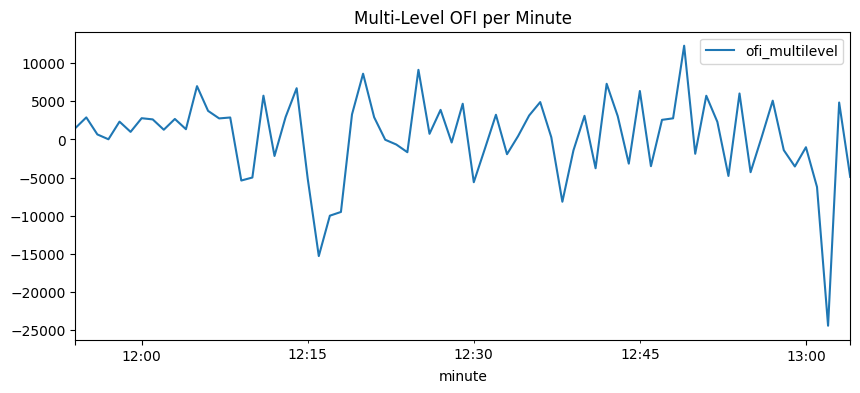

In [9]:
# Cell 7: (Optional) Visualize or Export

# Save to CSV
ofi_multi_per_minute.to_csv('ofi_multilevel_per_minute.csv', index=False)

# Or quick plot inline
ofi_multi_per_minute.plot(
    x='minute', y='ofi_multilevel',
    figsize=(10,4), title='Multi‐Level OFI per Minute'
)
